In [1]:
from IPython.display import clear_output 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import models, transforms
import sys
import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
import glob
from utils import *
from datetime import date

In [2]:
mean = [0.6821, 0.4575, 0.2626]
std = [0.1324, 0.1306, 0.1022]#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
from glaucomaDataloader import *
# ranknet = RankNet_wresnet()
cuda = torch.cuda.is_available()
glaucoma_test_dataset  = GlaucomaDataset("./datasets/annotated_eyes/", 
                                         phase="test", 
                                         datalen=1000,
                                         mode="mdindex-longtitude",
                                         transform = data_transforms['test'],
                                         seed=100)
# sampler = get_sampler_unbalance_set(glaucoma_train_dataset)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# glaucoma_train_loader = torch.utils.data.DataLoader(glaucoma_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
glaucoma_test_loader = torch.utils.data.DataLoader(glaucoma_test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


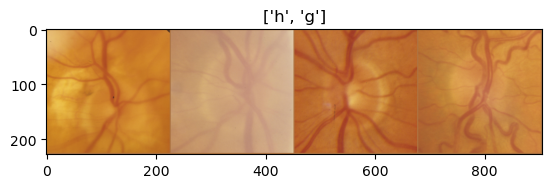

In [29]:
import torchvision
(inputs, _), classes, _ = next(iter(glaucoma_test_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in ['h', 'g']], mean=mean, std=std)

## Test 10-features siamese

In [4]:
from SimCLR.models.resnet_simclr import *

In [6]:
ressimclr = ResNetSimCLR('resnet50', 1000)
state_dict = torch.load('/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')
ressimclr.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [18]:
mode        = 'mdindex-longtitude'
fextractor  = 'vgg19'

ranknet = RankNet_wresnet2(feature_extractor = fextractor, cotrain = False)#, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')

In [61]:
mode        = 'mdindex-longtitude'
fextractor  = 'vgg19'

path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese10/{fextractor}/siaseme10_modemdindex-longtitude_fextravgg19_lr0.0005_mo0.9_e13_14102023_l10000_cotrainTrue.pt"
# path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex-latitude/siamese10/{fextractor}/siaseme10_modemdindex-latitude_fextravgg19_lr0.0005_mo0.9_e20_19102023_l10000_cotrainTrue.pt"
fcnet = nn.Sequential(torch.nn.Linear(2048, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 10))
ranknet = RankNet_wresnet2(feature_extractor = fextractor, fcnet=None)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
ranknet.eval()
ranknet.to(device)
# clear_output()

RankNet_wresnet2(
  (fextractor): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

In [62]:
# For siamese-10 only
predlist = []
labelist = []
problist = []

for e in range(1):
# Loop epoch
    losses = []
    # losses_val = []
    total_loss = 0
    temp_acc = 0
    comp_acc = 0
    val_acc = 0
    data_len = len(glaucoma_test_dataset)

    for batch_idx, (data, target, _) in enumerate(glaucoma_test_loader):
        # Training phase
        ranknet.eval()

        target = target.to(device)
        feature1 = data[0].to(device)
        feature2 = data[1].to(device)

        outputs = ranknet(feature1, feature2) #torch.squeeze(ranknet(feature1, feature2))
        # break
        pred = torch.argmax(outputs, 1)
        # comp_acc += torch.sum(target == pred).tolist()
        # comp_acc += torch.sum((target*1) == (outputs.flatten() > 0.5)*1).tolist()
        problist.append(pred.detach().cpu().numpy())
        labelist.append(target.detach().cpu().numpy()*1)
        predlist.append((torch.nn.functional.softmax(outputs)[:, 1].detach().cpu().numpy()))
    # print(f"epoch {e}: class acc is {temp_acc/data_len/2} --- comp acc is {comp_acc/data_len} --- loss is {total_loss/data_len}")

/tmp/ipykernel_330/3814000297.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predlist.append((torch.nn.functional.softmax(outputs)[:, 1].detach().cpu().numpy()))


KeyboardInterrupt: 

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print(classification_report(np.stack(labelist).flatten(), np.stack(problist).flatten(), digits=3))

              precision    recall  f1-score   support

           0      0.833     0.798     0.815       574
           1      0.742     0.784     0.763       426

    accuracy                          0.792      1000
   macro avg      0.787     0.791     0.789      1000
weighted avg      0.794     0.792     0.793      1000



In [12]:
accuracy_score(np.stack(labelist).flatten(), np.stack(problist).flatten())

0.739

0.8183677987503895

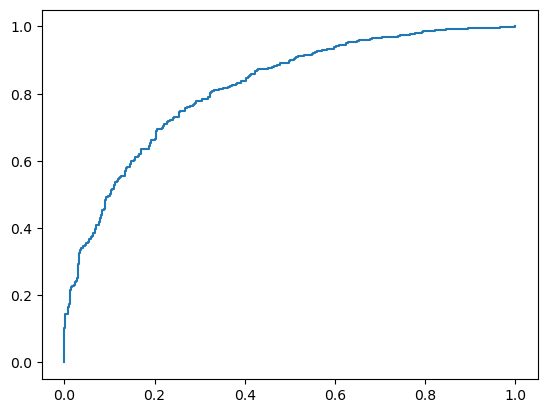

In [13]:
import sklearn.metrics as metrics

y_test = np.stack(labelist).flatten()
y_pred = np.stack(predlist).flatten()
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
roc_auc_score(y_test, y_pred)

## Test 1-features siamese

In [56]:
mode        = 'mdindex-longtitude'


fextractor = 'vgg19'
path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/vgg19/siaseme1_modemdindex-longtitude_fextravgg19_lr0.0005_mo0.9_e15_18092023_l10000_cotrainTrue.pt"
# path = '/mnt/c/Users/PCM/Documents/GitHub/Glaucoma-Ranking/pretrained/mdindex_siamese1/siaseme1_modemdindex-latitude_fextravgg19_lr0.0005_mo0.9_e19_20102023_l10000_cotrainTrue.pt'
fcnet = nn.Sequential(torch.nn.Linear(25088, 200),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(200, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 1))
ranknet = RankNet_wresnet(feature_extractor = fextractor, fcnet=fcnet)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
ranknet.eval()


RankNet_wresnet(
  (fextractor): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [57]:
# model = ranknet.model.eval()
# device='cpu'
ranknet.to(device)
predlist = []
labelist = []
problist = []
for e in range(1):
# Loop epoch
    losses = []
    # losses_val = []
    total_loss = 0
    temp_acc = 0
    comp_acc = 0
    val_acc = 0
    data_len = len(glaucoma_test_dataset)

    for batch_idx, (data, target, _) in enumerate(glaucoma_test_loader):
        # Training phase
        ranknet.eval()

        target = target.to(device)
        feature1 = data[0].to(device)
        feature2 = data[1].to(device)

        outputs = ranknet(feature1, feature2) #torch.squeeze(ranknet(feature1, feature2))
        # pred = torch.argmax(outputs, 1)
        # comp_acc += torch.sum((target*1) == (outputs.flatten() > 0.5)*1).tolist()
        problist.append(outputs.detach().cpu().numpy())
        labelist.append(target.detach().cpu().numpy()*1)
        predlist.append((outputs.detach().cpu().numpy() > 0.5)*1)
        # comp_acc += torch.sum((target*1) == (outputs.flatten() > 0.5)*1).tolist()

    # print(f"epoch {e}: class acc is {temp_acc/data_len/2} --- comp acc is {comp_acc/data_len} --- loss is {total_loss/data_len}")

In [60]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(np.stack(labelist).flatten(), np.stack(predlist).flatten(), digits=3))

              precision    recall  f1-score   support

           0      0.845     0.833     0.839       574
           1      0.779     0.793     0.786       426

    accuracy                          0.816      1000
   macro avg      0.812     0.813     0.812      1000
weighted avg      0.817     0.816     0.816      1000



In [9]:
roc_auc_score(np.stack(labelist).flatten(), np.stack(problist).flatten())

0.7446497974712607

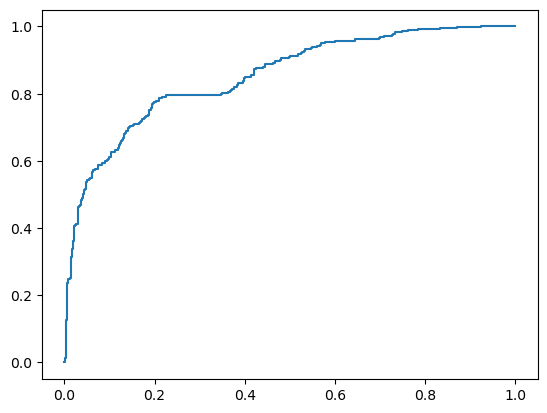

In [10]:
import sklearn.metrics as metrics

y_test = np.stack(labelist).flatten()
y_pred = np.stack(problist).flatten()
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

In [40]:
np.sum(y_test == (y_pred > 0.5)*1)/len(y_test)

0.8

# Testing Stuffs, Draft

In [1]:
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
from utils import *
from glaucomaDataloader import *


datalen     = 10
lr          = 1e-4
momentum    = 0.9
batch_size  = 4
mode        = 'mdindex-longtitude'
vallen      = 10
step_size   = 10
fextract    = 'vgg19'
# access_token = args.token
# transferData = TransferData(access_token)

print("--- Init parameters and Load dataset to local memory ---")
mean        = [0.6821, 0.4575, 0.2626]#[ 0.7013, -0.1607, -0.7902]#[0.485, 0.456, 0.406]
std         = [0.1324, 0.1306, 0.1022]#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

cuda = torch.cuda.is_available()
glaucoma_train_dataset = GlaucomaDataset("./datasets/annotated_eyes/", 
                                         phase="train", 
                                         mode=mode,
                                         datalen=datalen,
                                         transform = data_transforms['train']) # Returns pairs of images and target same/different
glaucoma_test_dataset = GlaucomaDataset("./datasets/annotated_eyes/", 
                                         phase="val", 
                                         mode=mode,
                                         datalen=vallen,
                                         transform = data_transforms['val'])

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
glaucoma_train_loader = torch.utils.data.DataLoader(glaucoma_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
glaucoma_test_loader = torch.utils.data.DataLoader(glaucoma_test_dataset, batch_size=batch_size, **kwargs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ranknet = RankNet_wresnet(feature_extractor=fextract, cotrain=True)
ranknet.to(device)
loss_fn = torch.nn.BCELoss()

optimizer = optim.SGD([{'params': ranknet.parameters()}], lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

optimizer.zero_grad()
acc_epoch = []

# print(f'begin training...with setting lr={lr}, momentum={momentum}, step_size={step_size}, datalen={datalen}, optimizer={optimizer}')
print("--- BEGIN Training ---")

for e in range(1):
    total_loss  = 0
    temp_acc    = 0
    comp_acc    = 0
    val_acc     = 0
    data_len    = datalen
    ranknet.train()

    for batch_idx, (data, target, _) in enumerate(glaucoma_train_loader):
        # Training phase
        target = target.to(device)
        feature1 = data[0].to(device)
        feature2 = data[1].to(device)

        outputs = ranknet(feature1, feature2) #torch.squeeze(ranknet(feature1, feature2))
        outputs_reverse = ranknet(feature2, feature1)

        loss1 = loss_fn(outputs.flatten(), (target*1).float())
        loss2 = loss_fn(outputs_reverse.flatten(), torch.abs(target*1-1).float())
        loss = loss1 

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        comp_acc += torch.sum((target*1) == (outputs.flatten() > 0.5)*1).tolist()
        
    ranknet.eval()
    
    for batch_idx, (data, target, _) in enumerate(glaucoma_test_loader):
        target = target.to(device)
        feature1 = data[0].to(device)
        feature2 = data[1].to(device)
        outputs = ranknet(feature1, feature2)
        val_acc += torch.sum((target*1) == (outputs.flatten() > 0.5)*1).tolist()

    scheduler.step()
    print(f"epoch {e}: With LR {optimizer.param_groups[0]['lr']} --- comp acc is {comp_acc/data_len} --- loss is {total_loss/data_len} --- Val acc is {val_acc/vallen}")

print('...DONE')

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Init parameters and Load dataset to local memory ---
cuda:0
--- BEGIN Training ---
epoch 0: With LR 0.0001 --- comp acc is 0.3 --- loss is 0.21293084621429442 --- Val acc is 0.4
...DONE


In [1]:
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
from utils import *
from glaucomaDataloader import *


datalen     = 10
lr          = 1e-4
momentum    = 0.9
batch_size  = 4
mode        = 'mdindex-longtitude'
vallen      = 10
step_size   = 10
fextract    = 'resnet50'
cotrain = True
print("Init")
mean        = [0.6821, 0.4575, 0.2626]#[ 0.7013, -0.1607, -0.7902]#[0.485, 0.456, 0.406]
std         = [0.1324, 0.1306, 0.1022]#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# ranknet = RankNet_wresnet()
cuda = torch.cuda.is_available()
glaucoma_train_dataset = GlaucomaDataset(phase="train", 
                                         mode=mode,
                                         datalen=datalen,
                                         transform = data_transforms['train']) # Returns pairs of images and target same/different
glaucoma_test_dataset = GlaucomaDataset(phase="val", 
                                         mode=mode,
                                         datalen=vallen,
                                         transform = data_transforms['val'])

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
glaucoma_train_loader = torch.utils.data.DataLoader(glaucoma_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
glaucoma_test_loader = torch.utils.data.DataLoader(glaucoma_test_dataset, batch_size=batch_size, **kwargs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ranknet = RankNet_wresnet2(feature_extractor=fextract, cotrain=True)
ranknet.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

if(cotrain):
    optimizer = optim.SGD([{'params': ranknet.parameters()}], lr=lr, momentum=momentum)
else:
    if(fextract == 'resnet50'):
        optimizer = optim.SGD([{'params': ranknet.fextractor.fc.parameters()}], lr=lr, momentum=momentum)
    else:
        optimizer = optim.SGD([{'params': ranknet.fextractor.classifier.parameters()}], lr=lr, momentum=momentum)

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

optimizer.zero_grad()
acc_epoch = []

# print(f'begin training...with setting lr={lr}, momentum={momentum}, step_size={step_size}, datalen={datalen}, optimizer={optimizer}')
print('Start training')
for e in range(2):
    total_loss = 0
    temp_acc = 0
    comp_acc = 0
    val_acc = 0
    data_len = len(glaucoma_train_dataset)
    ranknet.train()
    for batch_idx, (data, target, _) in enumerate(glaucoma_train_loader):
        # Training phase
        optimizer.zero_grad()
        target = target.to(device)
        feature1 = data[0].to(device)
        feature2 = data[1].to(device)

        outputs = ranknet(feature1, feature2) #torch.squeeze(ranknet(feature1, feature2))
        outputs_reverse = ranknet(feature2, feature1)
        loss1 = loss_fn(outputs, target)
        loss2 = loss_fn(outputs_reverse, torch.abs(target-1)) #For multitask learning
        loss = loss1 + loss2
        # losses.append(loss.item())

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        comp_acc += torch.sum(target == torch.max(outputs, 1)[1]).tolist()
    
    ranknet.eval()
    with torch.no_grad():
        for batch_idx, (data, target, _) in enumerate(glaucoma_test_loader):
            target = target.to(device)
            feature1 = data[0].to(device)
            feature2 = data[1].to(device)
            outputs = ranknet(feature1, feature2)
            val_acc += torch.sum(target == torch.max(outputs, 1)[1]).tolist()

    scheduler.step()
    print(f"epoch {e}: With LR {optimizer.param_groups[0]['lr']} --- comp acc is {comp_acc/data_len} --- loss is {total_loss/data_len} --- Val acc is {val_acc/vallen}")
    

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Init
cuda:0
Start training
epoch 0: With LR 0.0001 --- comp acc is 0.5 --- loss is 0.4135041832923889 --- Val acc is 0.6
epoch 1: With LR 0.0001 --- comp acc is 0.5 --- loss is 0.4156055212020874 --- Val acc is 0.6


In [2]:
ranknet.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 